<a href="https://colab.research.google.com/github/CatLAG0110/Analisis-ventas-LINIO/blob/main/PROYECTO_Reviews_de_aplicaciones_de_la_Google_Play_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GOOGLE PLAY STORE: Predicción de Raiting**


Dentro de Google Play Store, cada aplicación tiene valores de categoría, calificación de la App, tamaño, etc. 

La base de datos consiten 9 caracteristicas qur describen sus aplicaciones:
- App: Nombre de la app.
- Category: Categoría de la app (ARTE_Y_DISEÑO, FINANZAS, CÓMICS, BELLEZA, etc).
- Rating: La calificación promedio actual (de 5).
- Size: Tamaño de la aplicación en MB (megabytes).
- Installs: Número de veces que la aplicación se descargó de Google Play
- Type: Si la aplicación es de pago o gratuita.
- Price: Precio de la aplicación en  US$.
- Last Updated: Fecha en la que la aplicación se actualizó por última vez en Google Play.


In [1]:
#importamos las librerias necesarias para trabajar el dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import os
pd.set_option("display.max_columns", None) #Para visualizar todas las columnas.
sns.set_theme()

from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor #Modelo que se entrenara el dataset
from sklearn.model_selection import KFold # Para separar el dataset entre parte de entrenamiento/validación
from sklearn.model_selection import RandomizedSearchCV #fParámetro de Valizadación

##1. Exploración y Limpieza de datos:

In [2]:
#Conectar el drive para descargar el dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
val_na=["NA","Missing", "NaN", "None"]
df_googleapp = pd.read_csv("/content/drive/MyDrive/UCAMP/googleplaystore.csv", na_values=val_na)
df_googleapp.head() #Para visualizar el dataset

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
df_googleapp.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
df_googleapp.Reviews.str.isnumeric().sum()

10840

In [6]:
df_googleapp[~df_googleapp.Reviews.str.isnumeric()] #Para encontrar el valor que no es númerico

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


Se puede observar que los datos fueron mal ingresados por lo cual, se elinima esa fila.

In [7]:
df_googleapp = df_googleapp.drop(df_googleapp.index[10472])#se elimina la fila
df_googleapp["Reviews"] = df_googleapp["Reviews"].astype(float) # se convierten las Reviews en flotantes

En la columna "Size" se puede ver que los datos tienen prefijos métricos (Kilo y Mega) junto con otra cadena. Se reemplaza los k y M en valores a numéricos.

In [8]:
df_googleapp['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

In [9]:
df_googleapp['Size']=df_googleapp['Size'].str.replace('M','000')
df_googleapp['Size']=df_googleapp['Size'].str.replace('k','')

df_googleapp['Size']=df_googleapp['Size'].replace("Varies with device",np.nan)
df_googleapp['Size']=df_googleapp['Size'].astype('float')
df_googleapp['Size']

0        19000.0
1        14000.0
2            8.7
3        25000.0
4            2.8
          ...   
10836    53000.0
10837        3.6
10838        9.5
10839        NaN
10840    19000.0
Name: Size, Length: 10840, dtype: float64

In [10]:
#se crea una función para convertir los K a M
for i in df_googleapp['Size']:
    if i < 10:
        df_googleapp['Size']=df_googleapp['Size'].replace(i,i*1000)
df_googleapp['Size']=df_googleapp['Size']/1000
df_googleapp['Size']

0        19.0
1        14.0
2         8.7
3        25.0
4         2.8
         ... 
10836    53.0
10837     3.6
10838     9.5
10839     NaN
10840    19.0
Name: Size, Length: 10840, dtype: float64

Para la columna de Installs & Price se hace el mismo procedimiento anterior.

In [11]:
df_googleapp['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [12]:
items_to_remove=['+',',','$']
cols_to_clean=['Installs','Price']
for item in items_to_remove:
    for col in cols_to_clean:
        df_googleapp[col]=df_googleapp[col].str.replace(item,'')

df_googleapp['Installs']=df_googleapp['Installs'].astype('float')
df_googleapp['Price']=df_googleapp['Price'].astype('float')
df_googleapp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          9366 non-null   float64
 3   Reviews         10840 non-null  float64
 4   Size            9145 non-null   float64
 5   Installs        10840 non-null  float64
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  float64
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1.2+ MB


In [13]:
#Cambiar Last update a una columna de datetime
df_googleapp['Last Updated'] = pd.to_datetime(df_googleapp['Last Updated'])
df_googleapp['Last Updated']

0       2018-01-07
1       2018-01-15
2       2018-08-01
3       2018-06-08
4       2018-06-20
           ...    
10836   2017-07-25
10837   2018-07-06
10838   2017-01-20
10839   2015-01-19
10840   2018-07-25
Name: Last Updated, Length: 10840, dtype: datetime64[ns]

In [14]:
#Se separan el día, mes y año en una columna cada una
df_googleapp['Updated_Day']=df_googleapp['Last Updated'].dt.day
df_googleapp['Updated_Month']=df_googleapp['Last Updated'].dt.month
df_googleapp['Updated_Year']=df_googleapp['Last Updated'].dt.year
df_googleapp.drop('Last Updated', axis=1, inplace=True)
df_googleapp.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Updated_Day,Updated_Month,Updated_Year
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,Art & Design,1.0.0,4.0.3 and up,7,1,2018
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up,15,1,2018
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1.2.4,4.0.3 and up,1,8,2018
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25.0,50000000.0,Free,0.0,Teen,Art & Design,Varies with device,4.2 and up,8,6,2018
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,1.1,4.4 and up,20,6,2018


In [15]:
#Observamos que valores tienen NA
isnull = pd.DataFrame({'Null Values' : df_googleapp.isna().sum().sort_values(ascending=False), 
                     'Percentage Null Values' : (df_googleapp.isna().sum().sort_values(ascending=False)) / (df_googleapp.shape[0]) * (100)})
isnull

,Null Values,Percentage Null Values
Size,1695,15.636531
Rating,1474,13.597786
Current Ver,8,0.073801
Android Ver,2,0.018450
Type,1,0.009225
App,0,0.000000
Category,0,0.000000
Reviews,0,0.000000
Installs,0,0.000000
Price,0,0.000000


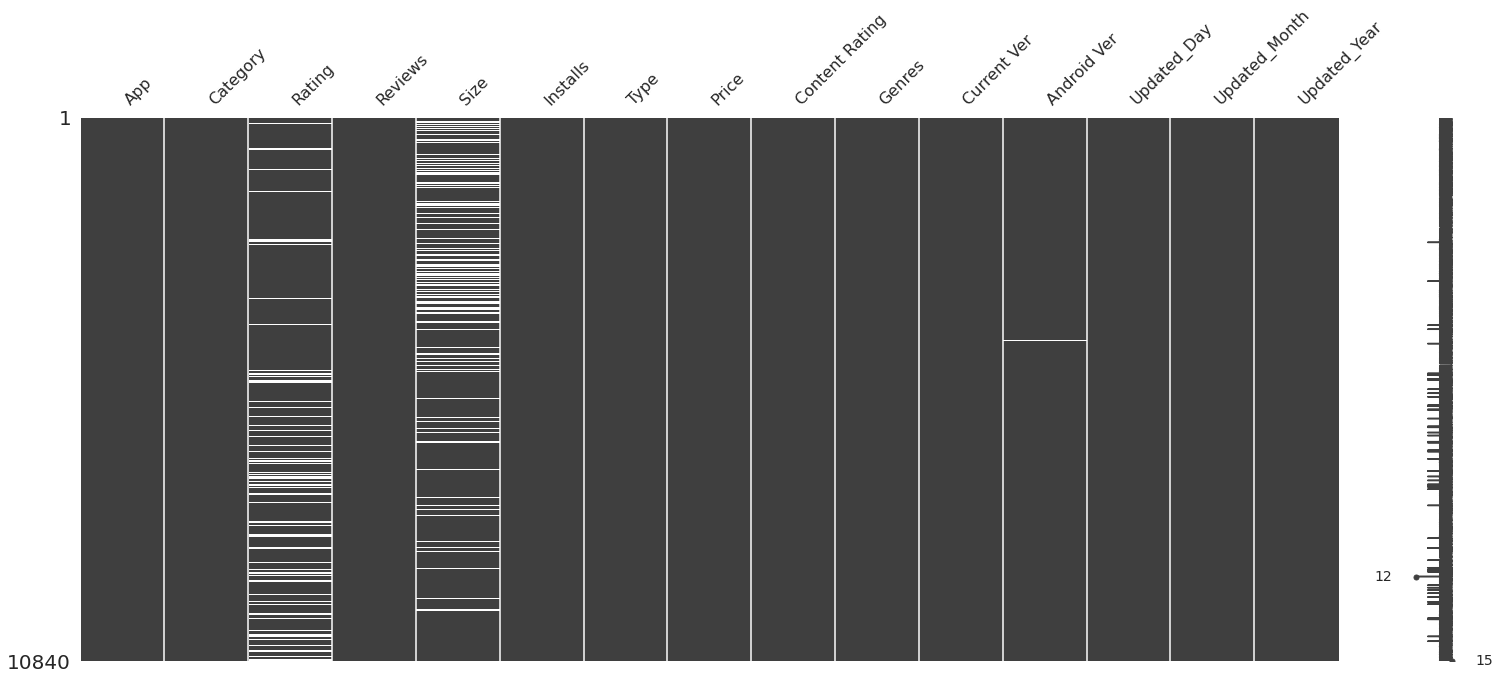

In [16]:
msno.matrix(df_googleapp)
plt.show()

Muchos valores faltantes están en las columnas Rating y Size. Se impian los valores faltantes usando la imputación de valores aleatorios con el fin de mantenr la distribución de cada función.

In [17]:
#Se crea una función para que sea más fácil la limpieza
def Random_value_imputation(feature):
    random_sample=df_googleapp[feature].dropna().sample(df_googleapp[feature].isnull().sum(),random_state=0)               
    random_sample.index=df_googleapp[df_googleapp[feature].isnull()].index
    df_googleapp.loc[df_googleapp[feature].isnull(),feature]=random_sample

    
for col in df_googleapp:
    Random_value_imputation(col)

In [18]:
duplicate = df_googleapp.duplicated()# número de duplicados
print(duplicate.sum())
df_googleapp.drop_duplicates(inplace=True)#eliminación de los duplicados

308


In [19]:
#Se identifican cuales son las variables numéricas del dataset
num_features= df_googleapp.select_dtypes(["float64","int64"]).columns #variables númericas
num_features

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Updated_Day',
       'Updated_Month', 'Updated_Year'],
      dtype='object')

In [20]:
num_data = df_googleapp[num_features]
num_data.head()

,Rating,Reviews,Size,Installs,Price,Updated_Day,Updated_Month,Updated_Year
0,4.1,159.0,19.0,10000.0,0.0,7,1,2018
1,3.9,967.0,14.0,500000.0,0.0,15,1,2018
2,4.7,87510.0,8.7,5000000.0,0.0,1,8,2018
3,4.5,215644.0,25.0,50000000.0,0.0,8,6,2018
4,4.3,967.0,2.8,100000.0,0.0,20,6,2018


In [21]:
#Se identifican cuales son las variables categóricas del dataset
cat_features= df_googleapp.select_dtypes(["object"]).columns #variables categoricas
cat_features

Index(['App', 'Category', 'Type', 'Content Rating', 'Genres', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [22]:
categorical=df_googleapp[cat_features]
categorical.head()

,App,Category,Type,Content Rating,Genres,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,Free,Everyone,Art & Design,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,Free,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,Free,Everyone,Art & Design,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,Free,Teen,Art & Design,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,Free,Everyone,Art & Design;Creativity,1.1,4.4 and up


#2. Visuzalización de los datos


 ### Analisis del tipo de App: Gratis vs Pagadas

In [26]:
typegoogleapp = df_googleapp["Type"].value_counts()
fig =px.bar(data_frame=typegoogleapp, title="Gratis vs Pagado", labels= ["Gratis", "Pagado"], orientation="v", text_auto="True", color=["Gratis", "Pagado"])
fig.update_traces(showlegend=False)
fig.show()

Con gráfica anterior se evidencia que el mercado para las aplicaciones que requieren pago es muy pequeño en comparación con el mercado de aplicaciones gratuitas. Apartir de esto uno se puede preguntar ¿Cual es la razón de que elmercado de apliciones pagas sea tan pequeño? ¿Tal vez la razón sea que las personas no quieren pagar por ellas? ¿O existe alguna otra razón?

In [27]:
fig= px.box(df_googleapp, x="Type", y = "Rating", color= "Type")
fig.show()

Se puede observar que la calificación promedio de las aplicaciones pagas es más alta. Ahora Observamos como es la distribución del Rating de las Apps

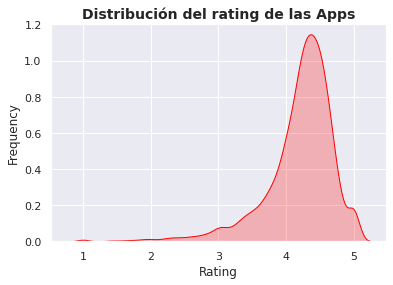

In [29]:
# distribución del rating de las Apps 
g = sns.kdeplot(df_googleapp.Rating, color="Red", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribución del rating de las Apps',fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.show()

Se observa que la mayoria de los valores tienen un Rating  entre 4 y 5.

Ahora vemos si existe alguna correlacion entre las variables a través de un gráfico de mapa de calor.

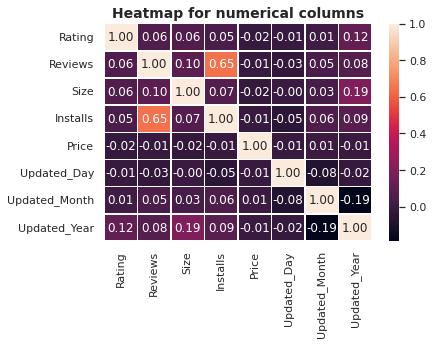

In [30]:
sns.heatmap(df_googleapp.corr(), annot = True, linewidths=.5, fmt=".2f")
plt.title("Heatmap for numerical columns", fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.show()

La relación entre las columnas "Installs" y "Reviews" es 0,65. Esto quiere decir que existe una correlación positiva de 0,65 entre el número de reseñas y el número de descargas. Lo que significa que los clientes descargan una aplicación determinada son las Apps que tienen mayor número de "Reviews".

### Análisis de Aps con Mayor intalaciones de acuerdo a la categoría y si son Pagas o Gratis

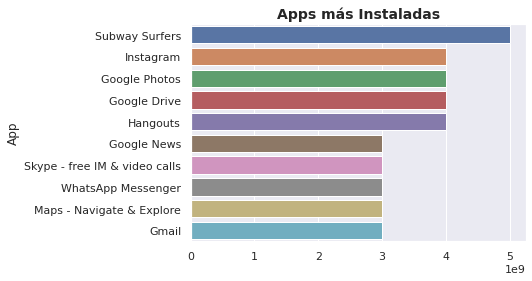

In [32]:
sns.set_style("darkgrid")
x=df_googleapp.groupby("App").Installs.sum().sort_values(ascending=False).head(10)
sns.barplot(x.values,x.index)
plt.title("Apps más Instaladas", fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.show()

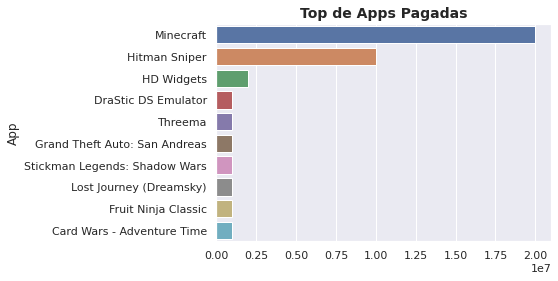

In [33]:
#Top de Apps Pagadas
x=df_googleapp[df_googleapp["Type"]=="Paid"]
y=x.groupby("App").Installs.sum().sort_values(ascending=False).head(10)
sns.barplot(y.values,y.index)
plt.title("Top de Apps Pagadas", fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.show()

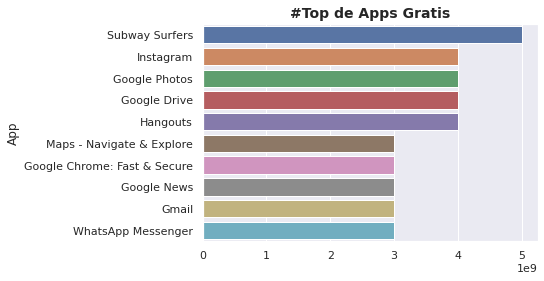

In [34]:
#Top de Apps Gratis
x=df_googleapp[df_googleapp["Type"]=="Free"]
y=x.groupby("App").Installs.sum().sort_values(ascending=False).head(10)
sns.barplot(y.values,y.index)
plt.title("#Top de Apps Gratis", fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.show()

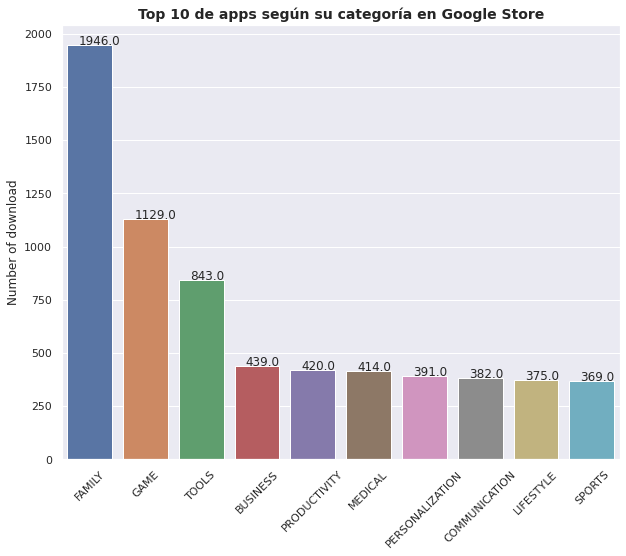

In [35]:
#Top 10 de apps según su categoría en google store
first_ten_index=df_googleapp["Category"].value_counts().head(10).index
first_ten_values=df_googleapp["Category"].value_counts().head(10).values
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=first_ten_index, y=first_ten_values ).set_title('Top 10 de apps según su categoría en Google Store',
                                                              fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.xticks(rotation=45)
ax.set_ylabel('Number of download', size =12)
for p in ax.patches: 
    ax.annotate(p.get_height(), (p.get_x()+0.2 , p.get_height()+0.3 ) )

### 3. Análisis de Rating de contenido

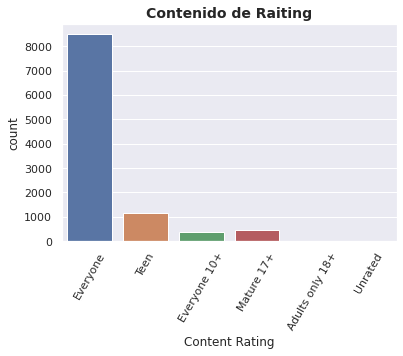

In [36]:
sns.countplot(x='Content Rating', data=df_googleapp)
plt.title('Contenido de Raiting', fontdict= { 'fontsize': 14,'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

Se observa que la mayoria de las categorias son aptas para  todo tipo de público.

# 3. Modelo de Predicción

Para esta parte, se hará dos modelos de predicción, uno de aprendizaje supervisado y otro sin aprendizaje supervizado

### 3.1 Cluster Segmantation de google store ( aprendizaje no supervisado) para predicción de Raiting de Apps

In [37]:
#Se eliminan las columnas inncesarias Versión actua, Versión para Android y el nombre de la App
df_googleapp.drop(labels=["Current Ver","Android Ver","App"],axis=1,inplace=True)

In [38]:
#se convierten las variables categoricas a númericas para poder correr el modelo
category_list = df_googleapp['Category'].unique().tolist()
category_list = ['cat_' + word for word in category_list]
df_googleapp = pd.concat([df_googleapp, pd.get_dummies(df_googleapp['Category'], prefix = 'cat')], axis = 1)
df_googleapp.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Updated_Day,Updated_Month,Updated_Year,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EDUCATION,cat_ENTERTAINMENT,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER
0,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,Art & Design,7,1,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15,1,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ART_AND_DESIGN,4.7,87510.0,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1,8,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ART_AND_DESIGN,4.5,215644.0,25.0,50000000.0,Free,0.0,Teen,Art & Design,8,6,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ART_AND_DESIGN,4.3,967.0,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20,6,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
#Encoding Géneros
le = LabelEncoder()
df_googleapp['Genres'] = le.fit_transform(df_googleapp['Genres'])
#Encoding "Content Rating" and "Tipo"
le = LabelEncoder()
df_googleapp['Content Rating'] = le.fit_transform(df_googleapp['Content Rating'])
df_googleapp=pd.concat([df_googleapp, pd.get_dummies(df_googleapp['Type'])], axis=1)

df_googleapp

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Updated_Day,Updated_Month,Updated_Year,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EDUCATION,cat_ENTERTAINMENT,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER,Free,Paid
0,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,1,9,7,1,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,1,12,15,1,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,ART_AND_DESIGN,4.7,87510.0,8.7,5000000.0,Free,0.0,1,9,1,8,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,ART_AND_DESIGN,4.5,215644.0,25.0,50000000.0,Free,0.0,4,9,8,6,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,ART_AND_DESIGN,4.3,967.0,2.8,100000.0,Free,0.0,1,11,20,6,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,FAMILY,4.5,38.0,53.0,5000.0,Free,0.0,1,39,25,7,2017,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10837,FAMILY,5.0,4.0,3.6,100.0,Free,0.0,1,39,6,7,2018,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10838,MEDICAL,4.6,3.0,9.5,1000.0,Free,0.0,1,71,20,1,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10839,BOOKS_AND_REFERENCE,4.5,114.0,2.6,1000.0,Free,0.0,3,19,19,1,2015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
#eliminamos las variables innecesarias y separamos las variables X y Y (es el valor que se busca predecir)
X = df_googleapp.drop(labels=["Rating", "Category", "Updated_Day","Updated_Month", "Updated_Year","Price","Type"], axis = 1)
y = df_googleapp['Rating']
X

,Reviews,Size,Installs,Content Rating,Genres,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EDUCATION,cat_ENTERTAINMENT,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER,Free,Paid
0,159.0,19.0,10000.0,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,967.0,14.0,500000.0,1,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,87510.0,8.7,5000000.0,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,215644.0,25.0,50000000.0,4,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,967.0,2.8,100000.0,1,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,38.0,53.0,5000.0,1,39,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10837,4.0,3.6,100.0,1,39,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10838,3.0,9.5,1000.0,1,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10839,114.0,2.6,1000.0,3,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [42]:
#Primero se divide el dataset entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

#Escalamos los datos usando el MinMaxScaler
scaler = MinMaxScaler()
scale = scaler.fit_transform(X)
df_scale = pd.DataFrame(scale, columns=X.columns);
df_scale.head(5)

,Reviews,Size,Installs,Content Rating,Genres,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EDUCATION,cat_ENTERTAINMENT,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER,Free,Paid
0,0.000002,0.189919,0.00001,0.2,0.076271,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000012,0.139914,0.00050,0.2,0.101695,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.001120,0.086909,0.00500,0.2,0.076271,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.002759,0.249925,0.05000,0.8,0.076271,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000012,0.027903,0.00010,0.2,0.093220,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
#Aplicamos un PCA para reducir la dimensión del dataset
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scale)
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
pca_df.head()

,principal component 1,principal component 2
0,-0.058815,0.258584
1,-0.069550,0.234484
2,-0.070495,0.236409
3,-0.030814,0.372808
4,-0.080480,0.214699


In [45]:
#Usamos el Coeficiente de Silueta para determinar el número optimos de K
for i in range(2,12):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(pca_df).labels_
    print ("Coeficiente de Silueta para k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(pca_df,labels,metric="euclidean",sample_size=1000,random_state=200)))

Coeficiente de Silueta para k(clusters) = 2 is 0.6383513261230768
Coeficiente de Silueta para k(clusters) = 3 is 0.6660689983188983
Coeficiente de Silueta para k(clusters) = 4 is 0.6104555550837563
Coeficiente de Silueta para k(clusters) = 5 is 0.6310872546141789
Coeficiente de Silueta para k(clusters) = 6 is 0.6562396586205658
Coeficiente de Silueta para k(clusters) = 7 is 0.6491510891465039
Coeficiente de Silueta para k(clusters) = 8 is 0.6069497440898999
Coeficiente de Silueta para k(clusters) = 9 is 0.6270621973658749
Coeficiente de Silueta para k(clusters) = 10 is 0.6399883824056177
Coeficiente de Silueta para k(clusters) = 11 is 0.6087466933916007


Se observa que ulnúmero optimode K es 3

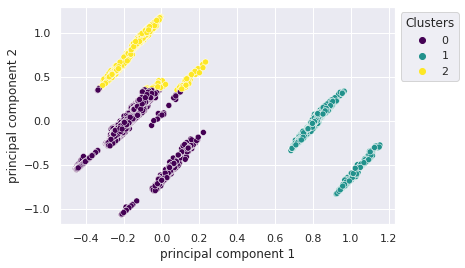

In [46]:
#Aplicamos un Kmeans con 3 Clusters (K=3)
kmeans = cluster.KMeans(n_clusters=3)
kmeans = kmeans.fit(pca_df)
y_predicted = kmeans.fit_predict(pca_df)

#Gráficamos los resultados
pca_df['Clusters'] =kmeans.labels_
sns.scatterplot(x="principal component 1", y="principal component 2",hue = 'Clusters',  data=pca_df, palette='viridis')
plt.legend(title="Clusters", loc = 2, bbox_to_anchor = (1,1))
plt.show()

### 3.2 Modelo Gradient Boosting ( aprendizaje supervisado) para predicción de Raiting de Apps

In [48]:
#Eliminamos las variables que no necesitamos
X = df_googleapp.drop(labels=["Rating", "Category", "Updated_Day","Updated_Month", "Updated_Year","Price","Type"], axis = 1)
y = df_googleapp['Rating']
X

,Reviews,Size,Installs,Content Rating,Genres,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,cat_BOOKS_AND_REFERENCE,cat_BUSINESS,cat_COMICS,cat_COMMUNICATION,cat_DATING,cat_EDUCATION,cat_ENTERTAINMENT,cat_EVENTS,cat_FAMILY,cat_FINANCE,cat_FOOD_AND_DRINK,cat_GAME,cat_HEALTH_AND_FITNESS,cat_HOUSE_AND_HOME,cat_LIBRARIES_AND_DEMO,cat_LIFESTYLE,cat_MAPS_AND_NAVIGATION,cat_MEDICAL,cat_NEWS_AND_MAGAZINES,cat_PARENTING,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER,Free,Paid
0,159.0,19.0,10000.0,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,967.0,14.0,500000.0,1,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,87510.0,8.7,5000000.0,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,215644.0,25.0,50000000.0,4,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,967.0,2.8,100000.0,1,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,38.0,53.0,5000.0,1,39,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10837,4.0,3.6,100.0,1,39,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10838,3.0,9.5,1000.0,1,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10839,114.0,2.6,1000.0,3,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [49]:
#Dividimos en dataset entre datos de entranimiento y prueba
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.75,random_state=0,shuffle=True)
#Usamos un MinMazScaler para normalizar el train dataset y test
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
#Hacemos una validación cruzada
crossval = KFold(n_splits=5, shuffle=True, random_state=0)


parameters = [{"loss":["squared_error", "absolute_error", "huber", "quantile"], 
               "criterion":["friedman_mse", "squared_error", "mse"]}
              ]

model = GradientBoostingRegressor()
clf = RandomizedSearchCV(estimator= model, param_distributions=parameters, cv=crossval, verbose=1 , n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions=[{'criterion': ['friedman_mse',
                                                       'squared_error', 'mse'],
                                         'loss': ['squared_error',
                                                  'absolute_error', 'huber',
                                                  'quantile']}],
                   verbose=1)

In [51]:
#creamos una tabla con los resultados de las combinaciones obtenidas desde la mejor a la peor
scores = pd.DataFrame(clf.cv_results_)
scores = scores.sort_values(by="rank_test_score").set_index("rank_test_score")
scores.head() #Solo escogemos las 5 primeras

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,0.953588,0.009638,0.003457,0.000254,squared_error,friedman_mse,"{'loss': 'squared_error', 'criterion': 'friedm...",0.099647,0.097818,0.105886,0.094907,0.097816,0.099215,0.003665
2,1.004907,0.027440,0.003907,0.001250,squared_error,mse,"{'loss': 'squared_error', 'criterion': 'mse'}",0.099636,0.097820,0.106047,0.094295,0.097818,0.099123,0.003871
3,0.951727,0.009442,0.004460,0.002258,squared_error,squared_error,"{'loss': 'squared_error', 'criterion': 'square...",0.099762,0.098470,0.105933,0.093178,0.097715,0.099012,0.004111
4,1.747276,0.382299,0.003666,0.000228,huber,squared_error,"{'loss': 'huber', 'criterion': 'squared_error'}",0.074805,0.098428,0.109590,0.082166,0.088622,0.090722,0.012218
5,1.455358,0.055915,0.003232,0.000251,huber,mse,"{'loss': 'huber', 'criterion': 'mse'}",0.074760,0.098428,0.109491,0.081753,0.088407,0.090568,0.012265


In [52]:
#finalmente uso los mejores valores de los hiperparámetros recién encontrados para entrenar todo el conjunto de entrenamiento original,
#evaluando su precisión en el conjunto de prueba, cuyos datos resultan como 'no vistos'

fitted_model = clf.best_estimator_

prediction = fitted_model.predict(X_test)
print('MAE:',round(metrics.mean_absolute_error(y_test,prediction), 3)) #evaluation
print('MSE:',round(metrics.mean_squared_error(y_test,prediction), 3))
print('r2 score: {}'.format(round((r2_score(y_test,prediction)),3)))

MAE: 0.347
MSE: 0.258
r2 score: 0.106
